

# Compare coordinate-based meta-regression and meta-analysis methods

A comparison between coordinate-based meta-regression (CBMR) and
coordinate-based meta-analysis (CBMA) in NiMARE

CBMR is a generative framework to approximate smooth activation intensity function and investigate
the effect of study-level moderators (e.g., year of publication, sample size, subtype of stimuli).
It allows flexible statistical inference for either spatial homogeneity tests or group comparison
tests. Additionally, it's a computationally efficient approach with good statistical
interpretability to model the locations of activation foci.

This tutorial is intended to provide an intuitive comparison of CBMA and MKDA results on
neurosynth dataset.

For more detailed introduction to CBMR implementation in NiMARE, see the [CBMR tutoral](https://nimare.readthedocs.io/en/latest/auto_examples/02_meta-analyses/11_plot_cbmr.html) and
[documatation](https://nimare.readthedocs.io/en/latest/generated/nimare.meta.cbmr.html).


In [1]:
!pip install git+https://github.com/yifan0330/NiMARE.git@fix_diagnostics_index

  Cloning https://github.com/yifan0330/NiMARE.git (to revision fix_diagnostics_index) to /private/var/folders/6z/dr8b0msn34dczlnpt0gt5ymmvxq11c/T/pip-req-build-8q1g_sza
  Running command git clone --filter=blob:none --quiet https://github.com/yifan0330/NiMARE.git /private/var/folders/6z/dr8b0msn34dczlnpt0gt5ymmvxq11c/T/pip-req-build-8q1g_sza
  Running command git checkout -b fix_diagnostics_index --track origin/fix_diagnostics_index
  Switched to a new branch 'fix_diagnostics_index'
  branch 'fix_diagnostics_index' set up to track 'origin/fix_diagnostics_index'.
  Resolved https://github.com/yifan0330/NiMARE.git to commit 69b01b4465aaacc853a87bc851dde47b9012a619
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os

from nimare.extract import download_abstracts, fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset
from nimare.meta import models
from nilearn.plotting import plot_stat_map

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Download the Neurosynth Dataset
Neurosynth is a large-scale functional magnetic resonance imaing (fMRI) database.
There are currently 507891 activations reported in 14371 studies in the Neurosynth
database, with interactive, downloadable meta-analyses of 1334 terms. There is also
a [platform](https://neurosynth.org/) designed for automated synthesis of fMRI data.



In [3]:
out_dir = os.path.abspath("../example_data/")
os.makedirs(out_dir, exist_ok=True)

files = fetch_neurosynth(
    data_dir=out_dir,
    version="7",
    overwrite=False,
    source="abstract",
    vocab="terms",
)
# Note that the files are saved to a new folder within "out_dir" named "neurosynth".
neurosynth_db = files[0]

neurosynth_dset = convert_neurosynth_to_dataset(
    coordinates_file=neurosynth_db["coordinates"],
    metadata_file=neurosynth_db["metadata"],
    annotations_files=neurosynth_db["features"],
)
neurosynth_dset.save(os.path.join(out_dir, "neurosynth_dataset.pkl.gz"))

neurosynth_dset = download_abstracts(neurosynth_dset, "example@example.edu")
neurosynth_dset.save(os.path.join(out_dir, "neurosynth_dataset_with_abstracts.pkl.gz"))

INFO:nimare.extract.utils:Dataset found in /Users/yifany/Documents/GitHub/NiMARE/examples/example_data/neurosynth

INFO:nimare.extract.extract:Searching for any feature files matching the following criteria: [('source-abstract', 'vocab-terms', 'data-neurosynth', 'version-7')]


File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.


INFO:nimare.extract.extract:Downloading chunk 1 of 16
INFO:nimare.extract.extract:Downloading chunk 2 of 16
INFO:nimare.extract.extract:Downloading chunk 3 of 16
INFO:nimare.extract.extract:Downloading chunk 4 of 16
INFO:nimare.extract.extract:Downloading chunk 5 of 16
INFO:nimare.extract.extract:Downloading chunk 6 of 16
INFO:nimare.extract.extract:Downloading chunk 7 of 16
INFO:nimare.extract.extract:Downloading chunk 8 of 16
INFO:nimare.extract.extract:Downloading chunk 9 of 16
INFO:nimare.extract.extract:Downloading chunk 10 of 16
INFO:nimare.extract.extract:Downloading chunk 11 of 16
INFO:nimare.extract.extract:Downloading chunk 12 of 16
INFO:nimare.extract.extract:Downloading chunk 13 of 16
INFO:nimare.extract.extract:Downloading chunk 14 of 16
INFO:nimare.extract.extract:Downloading chunk 15 of 16
INFO:nimare.extract.extract:Downloading chunk 16 of 16


For term-based meta-analyses, we split the whole Neurosynth dataset into two subsets,
one including all studies in the Neurosynth database whose abstracts include the term
at least once, the other including all the remaining studies. Here, we will conduct
meta-analyses based on the term "pain", and explore the spatial convergence between
pain studies and other fMRI studies.



In [4]:
# extract study_id for pain dataset and non-pain dataset
all_study_id = neurosynth_dset.annotations["id"]
pain_study_id = neurosynth_dset.get_studies_by_label(labels=["terms_abstract_tfidf__pain"])
non_pain_study_id = list(set(list(all_study_id)) - set(pain_study_id))  # 13855 studies
# add an additional column for group
neurosynth_dset.annotations.loc[all_study_id.isin(pain_study_id), "group"] = "pain"
neurosynth_dset.annotations.loc[all_study_id.isin(non_pain_study_id), "group"] = "non_pain"

## Estimation of group-specific spatial intensity functions
Now we are going to run CBMR framework on the Neurosynth Dataset and estimate
spatial intensity functions for both pain studies and non-pain fMRI studies.



In [5]:
from nimare.meta.cbmr import CBMREstimator

cbmr = CBMREstimator(
    group_categories="group",
    moderators=None,
    spline_spacing=10,  # a reasonable choice is 10 or 5, 100 is for speed
    model=models.PoissonEstimator,
    penalty=False,
    lr=1,
    tol=1e-9,  # a reasonable choice is 1e-2, 1e3 is for speed
    device="cpu",  # "cuda" if you have GPU
)
results = cbmr.fit(dataset=neurosynth_dset)

INFO:nimare.diagnostics:17510/507891 coordinates fall outside of the mask. Removing them.


Now that we have fitted the model, we can plot the spatial intensity maps.



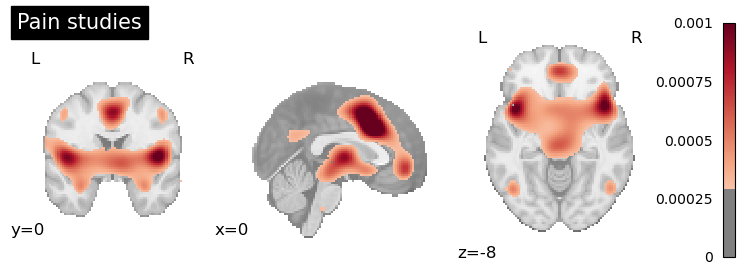

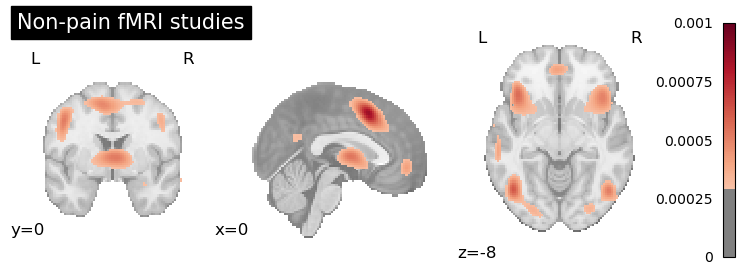

In [6]:
plot_stat_map(
    results.get_map("spatialIntensity_group-Pain"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="Pain studies",
    threshold=3e-4,
    vmax=1e-3,
)
plot_stat_map(
    results.get_map("spatialIntensity_group-Non_pain"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="Non-pain fMRI studies",
    threshold=3e-4,
    vmax=1e-3,
)

These two figures correspond to group-specific spatial intensity map of pain group
and non-pain group. Areas with stronger spatial intensity are highlighted.



## Group-wise tests for spatial homogeneity
For group-wise spatial homogeneity test, we generate contrast matrix *t_con_groups*
by specifying the group names in *create_contrast* function, and generate group-wise
p-value and z-score maps for spatial homogeneity tests.



In [7]:
from nimare.meta.cbmr import CBMRInference

inference = CBMRInference(device="cpu")
inference.fit(result=results)
t_con_groups = inference.create_contrast(["Pain", "Non_pain"], source="groups")
contrast_result = inference.transform(t_con_groups=t_con_groups)

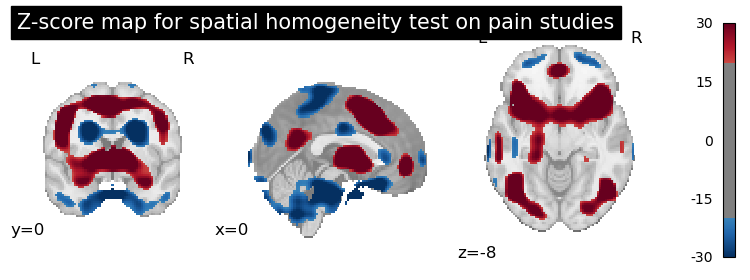

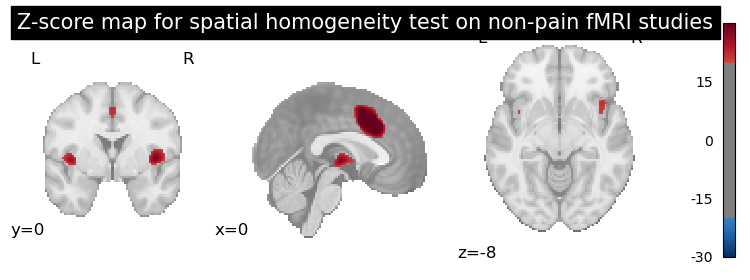

In [8]:
# generate z-score maps for group-wise spatial homogeneity test.
plot_stat_map(
    contrast_result.get_map("z_group-Pain"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="Z-score map for spatial homogeneity test on pain studies",
    threshold=20,
    vmax=30,
)

plot_stat_map(
    contrast_result.get_map("z_group-Non_pain"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="Z-score map for spatial homogeneity test on non-pain fMRI studies",
    threshold=20,
    vmax=30,
)

## Group comparison test between pain studies and non-pain fMRI studies
CBMR framework also allows flexible statistical inference for group comparison
between any two or more groups. For example, it's straightforward to generate
contrast matrix *t_con_groups* by specifying *contrast_name* as "group1-group2".



In [9]:
inference = CBMRInference(device="cpu")
inference.fit(result=results)
t_con_groups = inference.create_contrast(["Pain-Non_pain"], source="groups")
contrast_result = inference.transform(t_con_groups=t_con_groups)

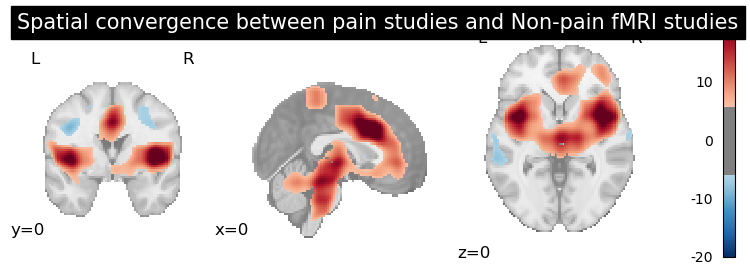

In [10]:
# generate z-statistics maps for each group
plot_stat_map(
    contrast_result.get_map("z_group-Pain-Non_pain"),
    cut_coords=[0, 0, 0],
    draw_cross=False,
    cmap="RdBu_r",
    title="Spatial convergence between pain studies and Non-pain fMRI studies",
    threshold=6,
    vmax=20,
)

This figure (displayed as z-statistics map) shows CBMR group comparison test
of spatial intensity between pain studies and non-pain studies in Neurosynth.
The null hypothesis assumes spatial intensity estimations of two groups are equal
at voxel level, $H_0: \mu_{1j}=\mu_{2j}, j=1,\cdots,N$, where $N$ is number of
voxels within brain mask, $j$ is the index of voxel. Areas with significant p-values
(significant difference in spatial intensity estimation between two groups) are
highlighted. We found that estimated activation level are significantly different
in ... between the pain group and non-pain group.



## Run MKDA on Neurosynth dataset
For the purpose of justifying the validity of CBMR framework, we compare the estimated
spatial convergence of activation regions between pain studies and non-pain fMRI studies
with MKDA.



INFO:nimare.dataset:Retaining 514/516 studies
INFO:nimare.dataset:Retaining 13805/13855 studies


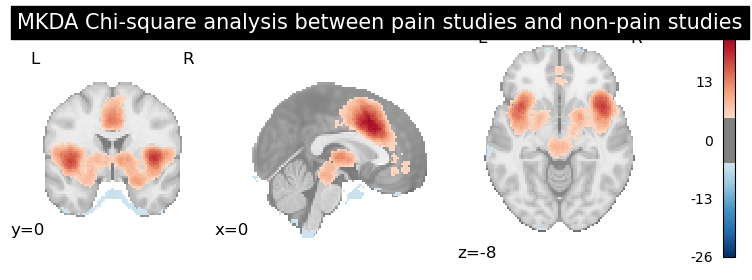

In [11]:
from nimare.meta.cbma.mkda import MKDAChi2

pain_dset = neurosynth_dset.slice(ids=pain_study_id)
non_pain_dset = neurosynth_dset.slice(ids=non_pain_study_id)

meta = MKDAChi2()
results = meta.fit(pain_dset, non_pain_dset)


plot_stat_map(
    results.get_map("z_desc-consistency"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="MKDA Chi-square analysis between pain studies and non-pain studies",
    threshold=5,
)

This figure (displayed as a z-statistics map) shows MKDA spatial covergence of
activation between pain studies and non-pain fMRI studies. We found the results are
very consistent with CBMR approach, with higher specificity but lower sensitivity.

